In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
cd /content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code


In [22]:
# Imports:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
import datetime

from load_and_process_data import process_data
from sklearn import preprocessing

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

### 1. Import all data into single pandas dataframe:

In [ ]:
# In jupyter import files like:
#datafolder = join(os.getcwd()[:os.getcwd().index('Code')]) + 'Data/ashrae-energy-prediction/'
#pd_all = process_data(datafolder)

In [ ]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)

In [ ]:
pd_all

,site_id,building_id,primary_use,square_feet,year_built,floor_count,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter,meter_reading
0,0,0,Education,7432,2008.0,5.0,2016-01-01 00:00:00,25.0,6.0,20.0,-1.0,1019.70,0.0,0.0,0,0.000
1,0,0,Education,7432,2008.0,5.0,2016-01-01 01:00:00,24.4,4.0,21.1,-1.0,1020.20,70.0,1.5,0,0.000
2,0,0,Education,7432,2008.0,5.0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.20,0.0,0.0,0,0.000
3,0,0,Education,7432,2008.0,5.0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.10,0.0,0.0,0,0.000
4,0,0,Education,7432,2008.0,5.0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.00,250.0,2.6,0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20125600,15,1448,Office,92271,2001.0,4.0,2016-12-31 19:00:00,3.0,1.0,-8.0,-1.0,1007.55,180.0,5.7,0,3.400
20125601,15,1448,Office,92271,2001.0,4.0,2016-12-31 20:00:00,2.8,2.0,-8.9,-1.0,1007.40,180.0,7.7,0,2.700
20125602,15,1448,Office,92271,2001.0,4.0,2016-12-31 21:00:00,2.8,2.0,-7.2,-1.0,1007.50,180.0,5.1,0,3.050
20125603,15,1448,Office,92271,2001.0,4.0,2016-12-31 22:00:00,2.2,2.0,-6.7,-1.0,1008.00,170.0,4.6,0,3.125


In [ ]:
dictionary_meter = {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
pd_all = pd_all.replace({'meter':dictionary_meter})
pd_all = pd.get_dummies(pd_all, columns = ['meter','primary_use'], prefix=['',''],prefix_sep=['',''])

In [ ]:
#list(pd_all)

In [ ]:
bins = [0,1940, 1980, np.inf] 
names = ['1900-1940', '1940-1980', '1980-today']

pd_all['year_range'] = pd.cut(pd_all['year_built'], bins, labels=names)

In [ ]:
pd_all = pd_all.drop(columns = 'year_built')

In [ ]:
len(list(pd_all))

34

In [ ]:
pd_all = pd.get_dummies(pd_all, columns = ['year_range'],prefix=[''],prefix_sep=[''])

In [ ]:
len(list(pd_all))

36

In [ ]:
#list(pd_all)

In [ ]:
pd_all = pd_all.drop(columns = 'site_id')

In [ ]:
#pd_all.describe().transpose()

In [ ]:
normalizer = preprocessing.Normalization()

In [ ]:
merged_train = pd_all.loc[(pd_all["electricity"]==1)]

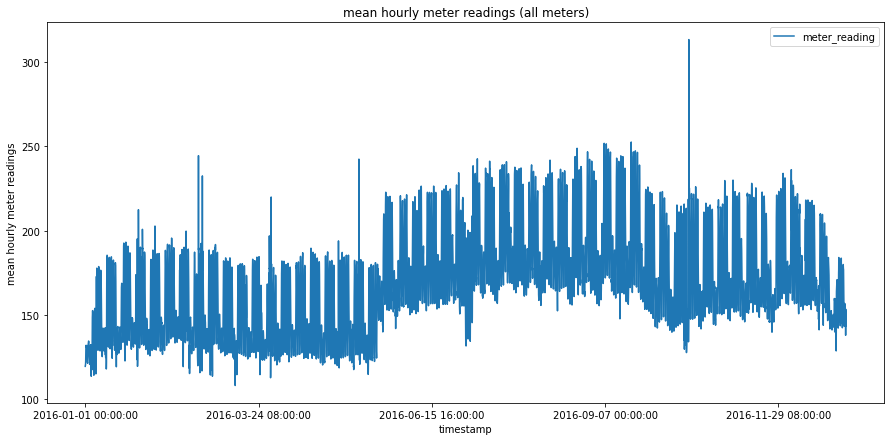

In [ ]:
merged_train.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

### 2. Let's try linear regression on a bit smaller data to get initial understanding of the tensorflow structure.

I will use only the features I strongly believe contribute to learning. Also I won't try one-hot encoding for now but I will try to do numeric encoding for all the features.

In [4]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)

In [5]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_initial = pd_all[['building_id','meter','timestamp','meter_reading', 'primary_use','square_feet','year_built','air_temperature']]
pd_init_elect = pd_initial.loc[(pd_initial["meter"]==0)]

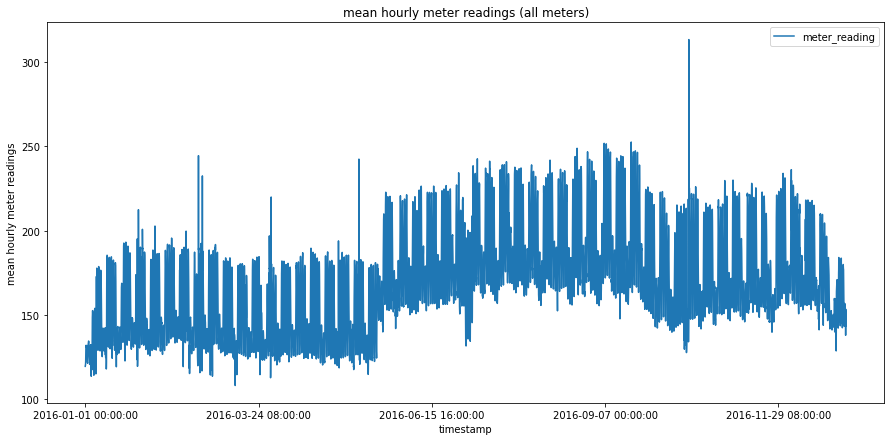

In [6]:
pd_init_elect.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [ ]:
pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 2, 1)

0            True
1            True
2            True
3            True
4            True
            ...  
20125600    False
20125601    False
20125602    False
20125603    False
20125604    False
Name: timestamp, Length: 12017408, dtype: bool

In [ ]:
pd_init_elect_fm = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 1, 2)]

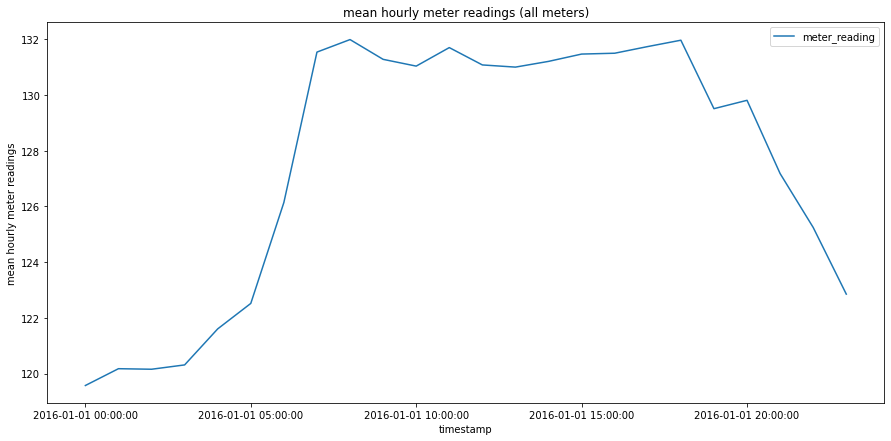

In [ ]:
pd_init_elect_fm.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

#### Split time into month, weekday, hour:

In [7]:
#### Split time into month, weekday, hour and am/pm:
pd_init_elect['month'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.month
pd_init_elect['weekday'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.weekday
pd_init_elect['hour'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.hour
#pd_init_elect['hour'] = pd_initial.loc[(pd.to_datetime(pd_init_elect["timestamp"]).dt.hour%12)]
#pd_init_elect['am'] = pd_initial.loc[(pd.to_datetime(pd_init_elect["timestamp"]).dt.hour<=12)]
                                

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

#### Split all data into training and testing data:

In [8]:
pd_train = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) > datetime.datetime(2016, 11, 30)]

#### Let's prepare dataset for tensorflow:

In [9]:
# Split training data:
#target = pd_train.pop('meter_reading')
timestamp_train = pd_train.pop('timestamp')
meter_train = pd_train.pop('meter')

In [10]:
# Convert primary_use into category:
pd_train['primary_use'] = pd_train.primary_use.astype('category').cat.codes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
#traindataset = tf.data.Dataset.from_tensor_slices((pd_train.values, target.values))

traindataset = (
    tf.data.Dataset.from_tensor_slices(
        (
            tf.cast(pd_train.values, tf.float32),
            tf.cast(target.values, tf.int32)
        )
    )
)

In [11]:
pd_train_subset = pd_train[['meter_reading','primary_use','square_feet','year_built','air_temperature','month','weekday','hour']]

In [12]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('meter_reading')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [13]:
trainingdata_subset = df_to_dataset(pd_train_subset)

In [14]:
## New try on the dataset:
pd_train_subset = pd_train[['meter_reading','primary_use','square_feet','year_built','air_temperature','month','weekday','hour']]
train_features = pd_train_subset.copy()

train_labels = train_features.pop('meter_reading')

In [15]:
## Let's normalize this data:
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[3.4077079e+00 9.2692023e+04 1.9689436e+03 1.6850967e+01 6.0518188e+00
 3.0004306e+00 1.1508832e+01]


In [16]:
linear_regression_model = keras.models.Sequential([
    normalizer,
    layers.Dense(units=1) # Linear Model
])

In [17]:
linear_regression_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 7)                 15        
_________________________________________________________________
dense (Dense)                (None, 1)                 8         
Total params: 23
Trainable params: 8
Non-trainable params: 15
_________________________________________________________________


In [18]:
loss = keras.losses.MeanSquaredError() # MeanSquaredError
optim = keras.optimizers.Adam(lr=0.1)

linear_regression_model.compile(optimizer=optim, loss=loss)

In [19]:
history = linear_regression_model.fit(
    train_features, train_labels,
    epochs=10,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/10
 37409/274953 [===>..........................] - ETA: 5:51 - loss: 115616.3926

KeyboardInterrupt: ignored

#### Let's make feature encoding:

In [ ]:
primary_use = tf.feature_column.numeric_column('primary_use')
square_feet = tf.feature_column.numeric_column('square_feet')
year_built = tf.feature_column.numeric_column('year_built')
air_temperature = tf.feature_column.numeric_column('air_temperature')
month = tf.feature_column.numeric_column('month')
weekday = tf.feature_column.numeric_column('weekday')
hour = tf.feature_column.numeric_column('hour')

feature_layer = tf.keras.layers.DenseFeatures([primary_use,square_feet,year_built,air_temperature,month,weekday,hour])

#### Let's make a linear_regression model:

In [ ]:
def linear_regression_model(learning_rate, feature_layer):
  model = tf.keras.models.Sequential()
  # add layer that is doing feature encoding:
  model.add(feature_layer)
  # add a fully-connected linear layer for linear regression:
  model.add(tf.keras.layers.Dense(units = 1)) # units is 1 because we are predicting just one number: meter_reading

  # Compile a model and define loss function and metric:
  model.compile(optimizer = keras.optimizers.Adam(lr = learning_rate), loss = tf.keras.losses.MeanSquaredError(), metrics = [tf.keras.metrics.RootMeanSquaredError()])

  return model

In [ ]:
# Hyperparameters
learning_rate = 0.001
epochs = 10
batch_size = 256

model = linear_regression_model(learning_rate, feature_layer)
model.fit(traindataset_subset.batch(batch_size), epochs=epochs, shuffle=True)

Epoch 1/10


ValueError: ignored

### 3. Let's try linear regression with smaller number of features on just one building:

In [23]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)

#### Looking at the plots I found that building 200 had a reasonable graph. I will try to fit data for this building:

In [406]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_initial = pd_all[['building_id','meter','timestamp','meter_reading', 'primary_use','square_feet','year_built','air_temperature']]
pd_init_elect = pd_initial.loc[(pd_initial["meter"]==0)]
pd_init_elect = pd_init_elect.loc[(pd_initial["building_id"]==200)]

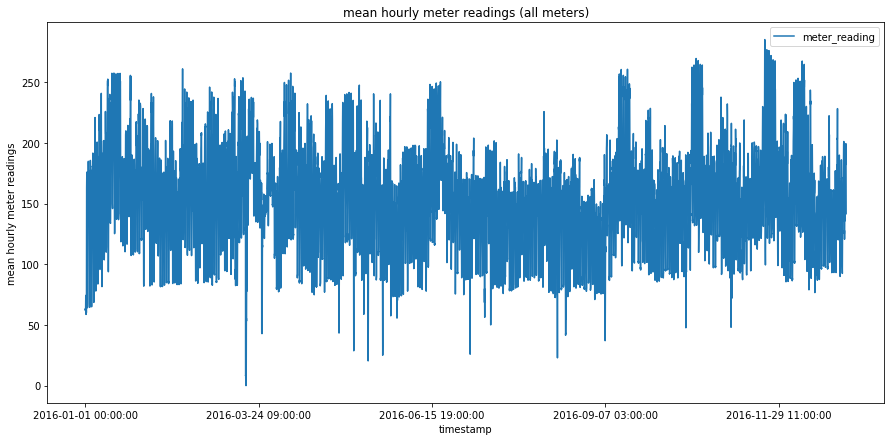

In [407]:
pd_init_elect.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [359]:
#### Split time into month, weekday, hour and am/pm:
pd_init_elect['month'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.month
pd_init_elect['weekday'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.weekday
pd_init_elect['hour'] = pd.to_datetime(pd_init_elect["timestamp"]).dt.hour

In [360]:
pd_train = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test = pd_init_elect.loc[pd.to_datetime(pd_init_elect["timestamp"]) > datetime.datetime(2016, 11, 30)]

In [361]:
timestamp_train = pd_train.pop('timestamp')
timestamp_test = pd_test.pop('timestamp')

pd_train.pop('meter')
pd_test.pop('meter')

2483829    0
2483832    0
2483835    0
2483838    0
2483841    0
          ..
2486112    0
2486115    0
2486118    0
2486121    0
2486124    0
Name: meter, Length: 766, dtype: int64

In [362]:
## New try on the dataset:
features = ['meter_reading','square_feet','year_built','air_temperature','month','weekday','hour']
pd_train_subset = pd_train[features]
train_features = pd_train_subset.copy()
pd_test_subset = pd_test[features]
test_features = pd_test_subset.copy()

train_labels = train_features.pop('meter_reading')
test_labels = test_features.pop('meter_reading')

In [363]:
#train_labels_norm =(train_labels - np.mean(train_labels))/np.std(train_labels)
#test_labels_norm = (test_labels - np.mean(train_labels))/np.std(train_labels) #normalize by train mean and std

In [364]:
## Let's normalize this data:
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[2.1960800e+05 1.9920000e+03 2.5951443e+01 6.0065947e+00 3.0008709e+00
 1.1501804e+01]


In [365]:
linear_regression_model = keras.models.Sequential([
    normalizer,
    layers.Dense(units=1) # Linear Model
])

In [366]:
linear_regression_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_11 (Normalizat (None, 6)                 13        
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 7         
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


In [368]:
loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=0.01)
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

In [369]:
history = linear_regression_model.fit(
    train_features, train_labels,
    epochs=20,
    verbose=1,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

Epoch 1/20
201/201 [==============================] - 1s 3ms/step - loss: 284562.4816 - val_loss: 312808.5625
Epoch 2/20
201/201 [==============================] - 0s 2ms/step - loss: 279223.0800 - val_loss: 314307.8750
Epoch 3/20
201/201 [==============================] - 0s 2ms/step - loss: 272458.4070 - val_loss: 315716.6562
Epoch 4/20
201/201 [==============================] - 0s 2ms/step - loss: 266891.9813 - val_loss: 317101.5312
Epoch 5/20
201/201 [==============================] - 0s 2ms/step - loss: 262792.0264 - val_loss: 318520.3438
Epoch 6/20
201/201 [==============================] - 0s 2ms/step - loss: 256212.9803 - val_loss: 319904.6562
Epoch 7/20
201/201 [==============================] - 0s 2ms/step - loss: 252149.1167 - val_loss: 321253.8438
Epoch 8/20
201/201 [==============================] - 0s 2ms/step - loss: 246314.7645 - val_loss: 322592.1875
Epoch 9/20
201/201 [==============================] - 0s 2ms/step - loss: 241670.0300 - val_loss: 323949.0000
Epoch 10/2

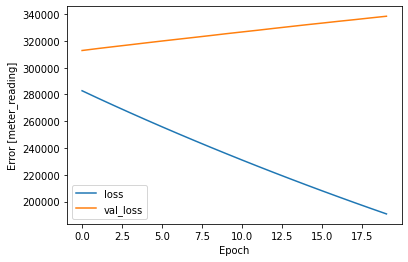

In [370]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [371]:
linear_regression_model.evaluate(
    test_features,
    test_labels, verbose=1)

24/24 [==============================] - 0s 1ms/step - loss: 378365.9062


378365.90625

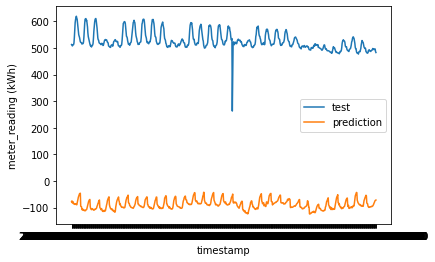

In [372]:
#range_min = np.min(test_features) - 10
#range_max = np.max(test_features) + 10
#x = tf.linspace(range_min, range_max, 200)
y = linear_regression_model.predict(test_features)
    
plt.plot(timestamp_test,test_labels, label = 'test')
plt.plot(timestamp_test,y, label = 'prediction')#*np.std(train_labels)+ np.mean(train_labels), label = 'prediction')
plt.ylabel('meter_reading (kWh)')
plt.xlabel('timestamp')
plt.legend()
plt.show()

### 4. Let's do a training on all Educational buildings with all the features as described above:

In [466]:
# Choose only building_id, timestamp, meter_reading, primary_use, square_feet, year_built,air_temperature as relevant features and choose only electricity as meter
pd_educational = pd_all[['building_id','meter','timestamp','meter_reading', 'primary_use','square_feet','year_built','air_temperature']]
pd_educational_elect = pd_educational.loc[(pd_educational["meter"]==0)]
#pd_educational_elect = pd_educational_elect.loc[(pd_educational_elect["primary_use"]=='Education')]

In [439]:
drop_ids = []
for i in pd_educational_elect.building_id.unique():
  meter_reading_values = pd_educational_elect.loc[(pd_educational["building_id"]==i)]['meter_reading']
  meter_reading_values_diff = np.diff(meter_reading_values)
  if sum(meter_reading_values_diff==0) > 10:
    drop_ids.append(i)

In [440]:
### Check how many building_ids have issues with meter_reading data:
print(len(drop_ids))
print(len(pd_educational_elect.building_id.unique()))
np.savetxt('dropids.txt', drop_ids)

1179
1413


In [467]:
pd_educational_elect_clean = pd_educational_elect[~pd_educational_elect.building_id.isin(drop_ids)]
choose_bld_ids = pd_educational_elect_clean.building_id.unique()
pd_educational_10build = pd_educational_elect_clean[pd_educational_elect_clean.building_id.isin(choose_bld_ids)]

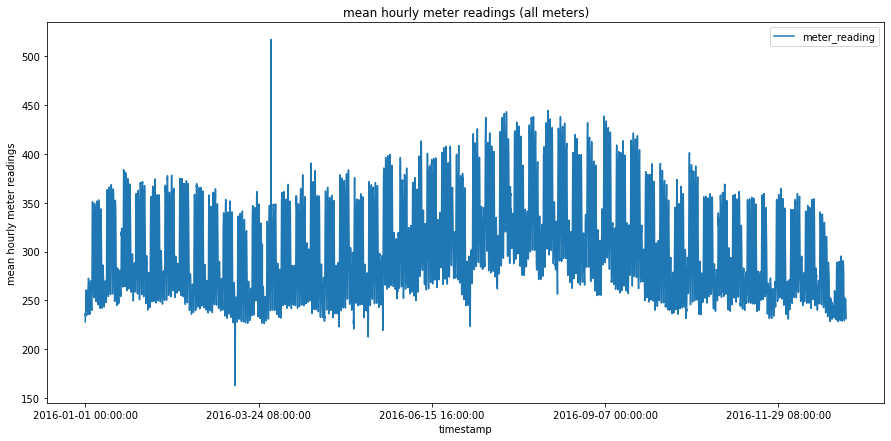

In [468]:
pd_educational_10build.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot(figsize =(15,7), ylabel = "mean hourly meter readings", title = "mean hourly meter readings (all meters)")

In [469]:
#### Split time into month, weekday, hour and am/pm:
pd_educational_10build['month'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.month
pd_educational_10build['weekday'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.weekday
pd_educational_10build['hour'] = pd.to_datetime(pd_educational_10build["timestamp"]).dt.hour

In [470]:
pd_train_educ = pd_educational_10build.loc[pd.to_datetime(pd_educational_10build["timestamp"]) < datetime.datetime(2016, 12, 1)]
pd_test_educ = pd_educational_10build.loc[pd.to_datetime(pd_educational_10build["timestamp"]) > datetime.datetime(2016, 11, 30)]

In [471]:
timestamp_train = pd_train_educ.pop('timestamp')
timestamp_test = pd_test_educ.pop('timestamp')

In [455]:
## New try on the dataset:
features = ['meter_reading','square_feet','year_built','air_temperature','month','weekday','hour']
pd_train_subset_educ = pd_train_educ[features]
train_features_educ = pd_train_subset_educ.copy()
pd_test_subset_educ = pd_test_educ[features]
test_features_educ = pd_test_subset_educ.copy()

train_labels_educ = train_features_educ.pop('meter_reading')
test_labels_educ = test_features_educ.pop('meter_reading')

In [456]:
#train_labels_norm_educ =(train_labels_educ - np.mean(train_labels_educ))/np.std(train_labels_educ)
#test_labels_norm_educ = (test_labels_educ - np.mean(train_labels_educ))/np.std(train_labels_educ) #normalize by train mean and std

## Let's normalize this data:
normalizer = preprocessing.Normalization()

# adapt to the data
normalizer.adapt(np.array(train_features_educ))
print(normalizer.mean.numpy())

[1.4893533e+05 1.9695244e+03 1.5745275e+01 6.0817471e+00 3.0004725e+00
 1.1510880e+01]


In [457]:
linear_regression_model = keras.models.Sequential([
    normalizer,
    layers.Dense(units=1) # Linear Model
])

linear_regression_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_12 (Normalizat (None, 6)                 13        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 20
Trainable params: 7
Non-trainable params: 13
_________________________________________________________________


In [458]:
loss = keras.losses.MeanSquaredError() # MeanSquaredError
#loss = keras.losses.MeanSquaredLogarithmicError()
optim = keras.optimizers.Adam(lr=0.01)
metrics=tf.keras.metrics.RootMeanSquaredError()

linear_regression_model.compile(optimizer=optim, loss=loss)#, metrics=metrics)

In [459]:
history = linear_regression_model.fit(
    train_features_educ, train_labels_educ,
    epochs=5,
    verbose=1,
    # Calculate validation results on 10% of the training data
    validation_split = 0.1)

Epoch 1/5
44503/44503 [==============================] - 78s 2ms/step - loss: 154042.2008 - val_loss: 131694.8750
Epoch 2/5
44503/44503 [==============================] - 77s 2ms/step - loss: 85345.3965 - val_loss: 129606.1719
Epoch 3/5
44503/44503 [==============================] - 76s 2ms/step - loss: 86106.3936 - val_loss: 129769.4141
Epoch 4/5
44503/44503 [==============================] - 76s 2ms/step - loss: 85790.6307 - val_loss: 129535.9766
Epoch 5/5
44503/44503 [==============================] - 76s 2ms/step - loss: 86086.0568 - val_loss: 129583.5859


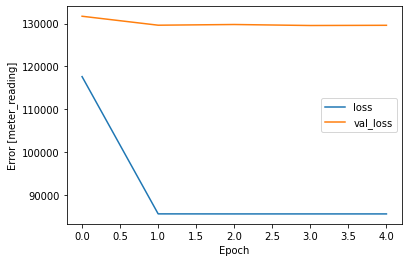

In [460]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

In [461]:
linear_regression_model.evaluate(
    test_features_educ,
    test_labels_educ, verbose=1)

5359/5359 [==============================] - 6s 1ms/step - loss: 66990.3438


66990.34375

In [493]:
test_features_educ_all = test_features_educ.copy()
test_features_educ_all['timestamp'] = timestamp_test.copy()
test_features_educ_all['meter_reading']  = test_labels_educ

y = linear_regression_model.predict(test_features_educ)
y_norm= pd.DataFrame(y, columns = ['prediction'])


y_norm['timestamp'] = np.array(timestamp_test)
y_norm
#test_features_educ_all.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]).plot()
#y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]).plot()

,prediction,timestamp
0,124.966370,2016-11-30 01:00:00
1,127.694000,2016-11-30 02:00:00
2,123.840225,2016-11-30 03:00:00
3,125.406433,2016-11-30 04:00:00
4,128.134064,2016-11-30 05:00:00
...,...,...
171458,192.694824,2016-12-31 19:00:00
171459,193.873901,2016-12-31 20:00:00
171460,195.440109,2016-12-31 21:00:00
171461,195.844879,2016-12-31 22:00:00


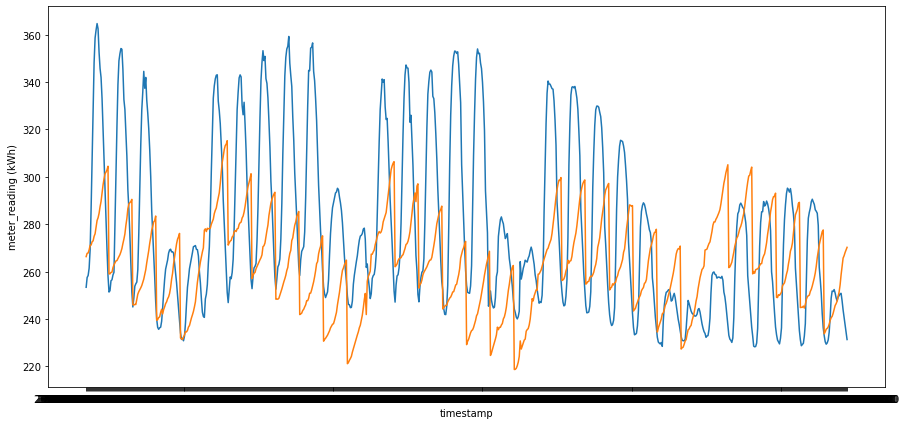

In [501]:
from matplotlib.pyplot import figure
figure(figsize =(15,7))
plt.plot(test_features_educ_all.groupby(by = "timestamp").mean().filter(["timestamp", "meter_reading"]))
plt.plot(y_norm.groupby(by = "timestamp").mean().filter(["timestamp", "prediction"]))
plt.xlabel('timestamp')
plt.ylabel('meter_reading (kWh)')
plt.show()